In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
from keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D, Add
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import RMSprop
from keras.utils import to_categorical

/home/user/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# increase input size to apply convolutions
def tile_array(a, b0, b1):
    r, c = a.shape
    rs, cs = a.strides 
    x = as_strided(a, (r, b0, c, b1), (rs, 0, cs, 0))
    return x.reshape(r*b0, c*b1)   

In [3]:
n_inds = 10
training_folders = ['0066', '0105']
validation_folders = ['0126']

In [4]:
for i,name in enumerate(training_folders):
    tmp = pd.read_hdf('/mnt/ssd1/Documents/Vivek/dnn/vision_leadership/golden_shiners/10_fish/' + name + '/' + name + '.h5')
    tmp['vid_id'] = i
    if i != 0:
        df_train = np.concatenate((df_train,tmp), axis=0)
    else:
        df_train = tmp
        
for i,name in enumerate(validation_folders):
    tmp = pd.read_hdf('/mnt/ssd1/Documents/Vivek/dnn/vision_leadership/golden_shiners/10_fish/' + name + '/' + name + '.h5')
    tmp['vid_id'] = i
    if i != 0:
        df_validation = np.concatenate((df_validation,tmp), axis=0)
    else:
        df_validation = tmp

df_train = pd.DataFrame(df_train)
df_validation = pd.DataFrame(df_validation)

df_train.columns = ['frame', 'ang_area_left_eye', 'ang_area_right_eye', 'f_id', 'n_id', 'cos_pos_left_eye', 'sin_pos_left_eye', 'cos_pos_right_eye', 'sin_pos_right_eye', 'leader', 'vid_id']
df_validation.columns = ['frame', 'ang_area_left_eye', 'ang_area_right_eye', 'f_id', 'n_id', 'cos_pos_left_eye', 'sin_pos_left_eye', 'cos_pos_right_eye', 'sin_pos_right_eye', 'leader', 'vid_id']

In [5]:
def generate_training_batch():
    vid_id = np.random.randint(0,len(training_folders))
    fr = np.random.randint(np.min(df_train['frame']),np.max(df_train['frame']))

    tmp = df_train[(df_train['vid_id'] == vid_id) & (df_train['frame'] == fr)]
    v1 = tile_array(np.array(tmp.pivot_table(index=['n_id'], columns='f_id', values='cos_pos_left_eye').reset_index())[:,1:], 50, 50)[...,np.newaxis]
    v2 = tile_array(np.array(tmp.pivot_table(index=['n_id'], columns='f_id', values='sin_pos_left_eye').reset_index())[:,1:], 50, 50)[...,np.newaxis]
    v3 = tile_array(np.array(tmp.pivot_table(index=['n_id'], columns='f_id', values='cos_pos_right_eye').reset_index())[:,1:], 50, 50)[...,np.newaxis]
    v4 = tile_array(np.array(tmp.pivot_table(index=['n_id'], columns='f_id', values='sin_pos_right_eye').reset_index())[:,1:], 50, 50)[...,np.newaxis]
    v5 = tile_array(np.array(tmp.pivot_table(index=['n_id'], columns='f_id', values='ang_area_left_eye').reset_index())[:,1:], 50, 50)[...,np.newaxis]
    v6 = tile_array(np.array(tmp.pivot_table(index=['n_id'], columns='f_id', values='ang_area_right_eye').reset_index())[:,1:], 50, 50)[...,np.newaxis]

    v = np.concatenate((v1,v2,v3,v4,v5,v6), axis=2)
    l = tile_array(np.array(tmp.pivot_table(index=['n_id'], columns='f_id', values='leader').reset_index())[:,1:], 50, 50)[...,np.newaxis]
    l = np.nan_to_num(l)
        
    x = np.pad(v, ((6,6), (6,6), (0,0)), mode='constant')
    y = np.pad(l, ((6,6), (6,6), (0,0)), mode='constant')
    
    return x[np.newaxis,...],y[np.newaxis,...]

In [6]:
vision, leader = generate_training_batch()
vision.shape, leader.shape

((1, 512, 512, 6), (1, 512, 512, 1))

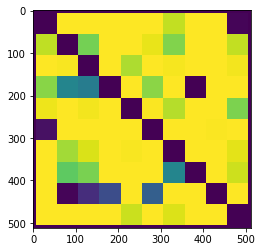

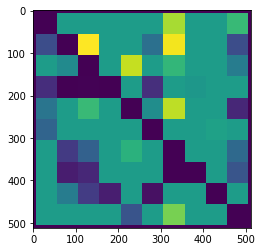

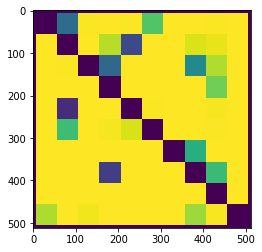

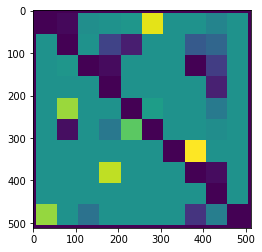

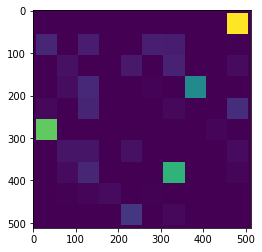

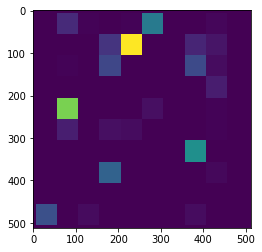

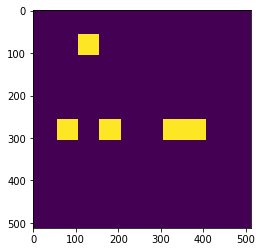

In [7]:
plt.imshow(np.squeeze(vision)[...,0].astype('uint8'))
plt.show()

plt.imshow(np.squeeze(vision)[...,1].astype('uint8'))
plt.show()

plt.imshow(np.squeeze(vision)[...,2].astype('uint8'))
plt.show()

plt.imshow(np.squeeze(vision)[...,3].astype('uint8'))
plt.show()

plt.imshow(np.squeeze(vision)[...,4].astype('uint8'))
plt.show()

plt.imshow(np.squeeze(vision)[...,5].astype('uint8'))
plt.show()

plt.imshow(np.squeeze(leader))
plt.show()

In [8]:
def generator():
    while(True):
        x, y = generate_training_batch()
    
        yield (x,y)

In [9]:
niters = 5
padding = 'same'

def pool_conv(conv_in, nfilters):
    pool = AveragePooling2D(pool_size=(2,2))(conv_in)
    conv = Conv2D(filters=nfilters, kernel_size=(3,3), padding=padding, activation='selu', use_bias=False)(pool)
    return pool, conv

def upsample_add_deconv(upsamp_in, res, nfilters):
    upsample = UpSampling2D(size=(2,2))(upsamp_in)
    add = Add()([res,upsample])
    deconv = Conv2D(filters=nfilters, kernel_size=(3,3), padding=padding, activation='selu', use_bias=False)(add)
    return upsample, add, deconv

In [10]:
input_layer = Input(batch_shape=(None, None, None, 6))

convs=[None]*niters
pools=[None]*(niters-1)
start_nfilters_exponent = 3        # 2**3 = 8 i.e. starting number of filters is 8

convs[0] = Conv2D(filters=2**start_nfilters_exponent, kernel_size=(3,3), padding=padding, activation='selu', use_bias=False)(input_layer)
for i in range(1,niters):
    pools[i-1], convs[i] = pool_conv(convs[i-1], 2**(start_nfilters_exponent+i))

ress=[None]*(niters-1)
for i in range(niters-1):
    ress[i] = Conv2D(filters=2**(start_nfilters_exponent+i+1), kernel_size=(3,3), padding=padding, activation='selu', use_bias=False)(convs[i])
    
upsamples=[None]*(niters-1)
adds=[None]*(niters-1)
deconvs=[None]*(niters-1)

upsamples[-1], adds[-1], deconvs[-1] = upsample_add_deconv(convs[-1], ress[-1], 2**(start_nfilters_exponent+len(ress)-1))
for i in range(niters-2,0,-1):
    upsamples[i-1], adds[i-1], deconvs[i-1] = upsample_add_deconv(deconvs[i], ress[i-1], 2**(start_nfilters_exponent+i-1))

output_layer = Conv2D(filters=1, kernel_size=(3,3), padding=padding, activation='selu')(deconvs[0])

model = Model(input_layer, output_layer)
model.compile(RMSprop(lr=2e-4), loss='mse')

In [ ]:
model.fit_generator(generator(), 1000, 10, workers=8, use_multiprocessing=True)

/home/user/.local/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
   5/1000 [..............................] - ETA: 8:15 - loss: 4223.7296 

In [27]:
input_layer = Input(batch_shape=(None, None, 6))

convs=[None]*niters
pools=[None]*(niters-1)
start_nfilters_exponent = 3        # 2**3 = 8 i.e. starting number of filters is 8

convs[0] = Conv1D(filters=2**start_nfilters_exponent, kernel_size=3, padding=padding, activation='selu', use_bias=False)(input_layer)
for i in range(1,niters):
    pools[i-1], convs[i] = pool_conv(convs[i-1], 2**(start_nfilters_exponent+i))

ress=[None]*(niters-1)
for i in range(niters-1):
    ress[i] = Conv1D(filters=2**(start_nfilters_exponent+i+1), kernel_size=1, padding=padding, activation='selu', use_bias=False)(convs[i])
    
upsamples=[None]*(niters-1)
adds=[None]*(niters-1)
deconvs=[None]*(niters-1)

upsamples[-1], adds[-1], deconvs[-1] = upsample_add_deconv(convs[-1], ress[-1], 2**(start_nfilters_exponent+len(ress)-1))
for i in range(niters-2,0,-1):
    upsamples[i-1], adds[i-1], deconvs[i-1] = upsample_add_deconv(deconvs[i], ress[i-1], 2**(start_nfilters_exponent+i-1))

output_layer = Conv1D(filters=1, kernel_size=3, padding=padding, activation='linear')(deconvs[0])

model = Model(input_layer, output_layer)
model.compile(Adam(lr=0.001, amsgrad=True), loss='binary_crossentropy')

In [28]:
half_batch = 4096
def generate_training_batch():
    vid_id = np.random.randint(0,len(training_folders))
    f_id = np.random.randint(0,n_inds)
    while (True):
        n_id = np.random.randint(0,n_inds)
        if n_id != f_id:
            break
    tmp = df_train[(df_train['vid_id'] == vid_id) & (df_train['f_id'] == f_id) & (df_train['n_id'] == n_id)]
    
    idx = np.random.randint(half_batch,tmp.shape[0]-half_batch)
    x = tmp[idx-half_batch:idx+half_batch][['ang_area_left_eye', 'ang_area_right_eye', 'cos_pos_left_eye', 'sin_pos_left_eye', 'cos_pos_right_eye', 'sin_pos_right_eye']].values[None,...]
    y = tmp[idx-half_batch:idx+half_batch][['leader']].values[None,...]
    
    return x,y

def generate_validation_batch():
    vid_id = np.random.randint(0,len(validation_folders))
    f_id = np.random.randint(0,n_inds)
    while (True):
        n_id = np.random.randint(0,n_inds)
        if n_id != f_id:
            break
    tmp = df_validation[(df_validation['vid_id'] == vid_id) & (df_validation['f_id'] == f_id) & (df_validation['n_id'] == n_id)]
    
    idx = np.random.randint(half_batch,tmp.shape[0]-half_batch)
    x = tmp[idx-half_batch:idx+half_batch][['ang_area_left_eye', 'ang_area_right_eye', 'cos_pos_left_eye', 'sin_pos_left_eye', 'cos_pos_right_eye', 'sin_pos_right_eye']].values[None,...]
    y = tmp[idx-half_batch:idx+half_batch][['leader']].values[None,...]
    
    return x,y

def training_generator(batch_size):
    while(True):
        x=[]
        y=[]
        for idx in range(batch_size):
            tmpx,tmpy = generate_training_batch()
            x.append(tmpx)
            y.append(tmpy)
        
        x = np.vstack(x)
        y = np.vstack(y)
        yield (x,y)
        
def validation_generator(batch_size):
    while(True):
        x=[]
        y=[]
        for idx in range(batch_size):
            tmpx,tmpy = generate_validation_batch()
            x.append(tmpx)
            y.append(tmpy)
        
        x = np.vstack(x)
        y = np.vstack(y)
        yield (x,y)

In [33]:
#a = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0)
#b = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0)
model.fit_generator(training_generator(1), 500, 20, workers=8, use_multiprocessing=True)

/home/user/.local/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
500/500 [==============================] - 9s 17ms/step - loss: 1.1472
Epoch 2/20
500/500 [==============================] - 8s 17ms/step - loss: 1.1180
Epoch 3/20
500/500 [==============================] - 8s 17ms/step - loss: 1.0824
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 1.1968
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 1.1581
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 1.1038
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 1.1732
Epoch 8/20
500/500 [==============================] - 8s 17ms/step - loss: 1.1575
Epoch 9/20
500/500 [==============================] - 9s 17ms/step - loss: 1.2078
Epoch 10/20
500/500 [==============================] - 9s 17ms/step - loss: 1.1573
Epoch 11/20
500/500 [==============================] - 9s 17ms/step - loss: 1.1173
Epoch 12/20
500/500 [==============================] - 9s 18ms/step - loss: 1.1591
Epoch 13/20
5